# Basic System

This notebook provides code for implementing a very simple machine learning system for named entity recognition.
It uses logistic regression and one feature (the token itself).
Links to information about the packages are provided. Your job is to document the code and use it to train a system. You can then use your evaluation code to provide the first basic evaluation of your system.

*Note:* In the next assignment, you can use this as a basis to experiment with more features and more machine learning methods.

### About this Notebook:
- The notebook is structured similarly to the assignment pdf. Each question contains suggestions to help guide you, but remember to follow the requirements in the PDF for your final answers.

In [1]:
from collections import defaultdict, Counter
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import gensim
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import sys
import os

# If you want to include other modules, you can add them here
# Please note the recommendations on using modules in the Programming General Guidelines

#recommended resource for examples: https://scikit-learn.org/stable/modules/feature_extraction.html




/home/andres/Desktop/ma-ml4nlp-labs/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2.1. Load and inspect the data
**Suggestions:**
 - Download the following files form from canvas ,and place them in the folder "`./data/conll2003`":
   - `conll2003.train.conll`, `conll2003.test.conll`, `conll2003.dev.conll`


In [2]:
def extract_features(inputfile):
    """Helper function to parse a document in CONLL format and build a feature dictionary for each token"""   
    data = []
    with open(inputfile, 'r', encoding='utf8') as infile:
        for line in infile:
            components = line.rstrip('\n').split()
            if len(components) > 0:
                token = components[0]
                feature_dict = {'token':token}
                data.append(feature_dict)
    return data

In [3]:
def extract_features_and_labels(trainingfile, word_embedding_model, word_counts=None, ngram_range=(2, 3)):
    """
    Extract features for NER, including word frequency, n-grams, and word embeddings.
    """
    # Compute word counts if not provided for BoW
    if word_counts is None:
        word_counts = Counter()
        with open(trainingfile, 'r', encoding='utf8') as infile:
            for line in infile:
                components = line.rstrip('\n').split()
                if components:  # Non-empty line
                    token = components[0]
                    word_counts[token] += 1

    data = []
    targets = []
    length_bins = [(1, 3), (4, 6), (7, float('inf'))]
    embedding_dim = word_embedding_model.vector_size  # Embedding dimension

    with open(trainingfile, 'r', encoding='utf8') as infile:
        lines = infile.readlines()

    for i, line in enumerate(lines):
        components = line.rstrip('\n').split()
        if components:  # Non-empty line
            token = components[0]
            pos_tag = components[1]
            chunk_tag = components[2]
            ner_tag = components[3]

            # Base features
            feature_dict = {
                'token': token,
                'pos_tag': pos_tag,
                'chunk_tag': chunk_tag,
                'capitalized': token[0].isupper(),
                'token_length': len(token),
                'contains_digit': any(char.isdigit() for char in token),
                'word_frequency': word_counts[token] / len(word_counts)
            }

            # Token length binning
            for idx, (low, high) in enumerate(length_bins):
                if low <= len(token) <= high:
                    feature_dict['token_length_bin'] = f'bin_{idx}'
                    break

            # Add contextual features
            if i > 0 and lines[i - 1].strip():
                feature_dict['prev_pos_tag'] = lines[i - 1].split()[1]
            else:
                feature_dict['prev_pos_tag'] = '<START>'
            if i < len(lines) - 1 and lines[i + 1].strip():
                feature_dict['next_pos_tag'] = lines[i + 1].split()[1]
            else:
                feature_dict['next_pos_tag'] = '<END>'

            # Add n-gram features
            for n in range(ngram_range[0], ngram_range[1] + 1):
                feature_dict[f'prefix_{n}'] = token[:n] if len(token) >= n else '<PAD>'
                feature_dict[f'suffix_{n}'] = token[-n:] if len(token) >= n else '<PAD>'

            # Add word embedding as a dense feature
            if token in word_embedding_model:
                embedding = word_embedding_model[token]
            else:
                embedding = np.zeros(embedding_dim)  # Use a zero vector if token is not in the embeddings
            feature_dict['embedding'] = embedding

            # Append features and target
            data.append(feature_dict)
            targets.append(ner_tag)

    return data, targets

In [4]:
def extract_features_and_labels_down(trainingfile, word_embedding_model, word_counts=None, ngram_range=(2, 3)):
    """
    Extract features for NER, including word frequency, n-grams, and word embeddings.
    Applies downsampling to reduce the "O" class while keeping informative "O" tokens.
    """
    # Compute word counts if not provided for BoW
    if word_counts is None:
        word_counts = Counter()
        with open(trainingfile, 'r', encoding='utf8') as infile:
            for line in infile:
                components = line.rstrip('\n').split()
                if components:  # Non-empty line
                    token = components[0]
                    word_counts[token] += 1

    data = []
    targets = []
    length_bins = [(1, 3), (4, 6), (7, float('inf'))]
    embedding_dim = word_embedding_model.vector_size  # Embedding dimension

    with open(trainingfile, 'r', encoding='utf8') as infile:
        lines = infile.readlines()

    for i, line in enumerate(lines):
        components = line.rstrip('\n').split()
        if components:  # Non-empty line
            token = components[0]
            pos_tag = components[1]
            chunk_tag = components[2]
            ner_tag = components[3]

            # Downsampling 
            if ner_tag == "O":
                prev_tag = lines[i - 1].rstrip('\n').split()[3] if i > 0 and lines[i - 1].strip() else None
                next_tag = lines[i + 1].rstrip('\n').split()[3] if i < len(lines) - 1 and lines[i + 1].strip() else None

                # Skip this "O" token if it is not adjacent to any entity tag
                if (prev_tag is None or prev_tag == "O") and (next_tag is None or next_tag == "O"):
                    continue

            # Base features
            feature_dict = {
                'token': token,
                'pos_tag': pos_tag,
                'chunk_tag': chunk_tag,
                'capitalized': token[0].isupper(),
                'token_length': len(token),
                'contains_digit': any(char.isdigit() for char in token),
                'word_frequency': word_counts[token] / len(word_counts)
            }

            # Token length binning
            for idx, (low, high) in enumerate(length_bins):
                if low <= len(token) <= high:
                    feature_dict['token_length_bin'] = f'bin_{idx}'
                    break

            # Add contextual features
            if i > 0 and lines[i - 1].strip():
                feature_dict['prev_pos_tag'] = lines[i - 1].split()[1]
            else:
                feature_dict['prev_pos_tag'] = '<START>'
            if i < len(lines) - 1 and lines[i + 1].strip():
                feature_dict['next_pos_tag'] = lines[i + 1].split()[1]
            else:
                feature_dict['next_pos_tag'] = '<END>'

            # Add n-gram features
            for n in range(ngram_range[0], ngram_range[1] + 1):
                feature_dict[f'prefix_{n}'] = token[:n] if len(token) >= n else '<PAD>'
                feature_dict[f'suffix_{n}'] = token[-n:] if len(token) >= n else '<PAD>'

            # Add word embedding as a dense feature
            if token in word_embedding_model:
                embedding = word_embedding_model[token]
            else:
                embedding = np.zeros(embedding_dim)  # Use a zero vector if token is not in the embeddings
            feature_dict['embedding'] = embedding

            # Append features and target
            data.append(feature_dict)
            targets.append(ner_tag)

    return data, targets


In [5]:
def create_dataframe(data, targets):
    """Helper function to turn the datasets into dataframes"""   
    records = []
    for features, target in zip(data, targets):
        record = features.copy()
        record['NER'] = target
        records.append(record)
    
    return pd.DataFrame(records)

In [6]:
data_folder = "../../data/conll2003/"

train_file = data_folder + "conll2003.train.conll"
test_file = data_folder + "conll2003.test.conll"
dev_file = data_folder + "conll2003.dev.conll"
embeddings_file = "../../data/vecs/GoogleNews-vectors-negative300.bin.gz"
word_embedding_model = gensim.models.KeyedVectors.load_word2vec_format(embeddings_file, binary=True)


In [7]:
train_data, train_targets = extract_features_and_labels(train_file, word_embedding_model=word_embedding_model)
# train_data_down, train_targets_down = extract_features_and_labels_down(train_file, word_embedding_model=word_embedding_model)

test_data, test_targets = extract_features_and_labels(test_file, word_embedding_model=word_embedding_model)
dev_data, dev_targets = extract_features_and_labels(dev_file, word_embedding_model=word_embedding_model)

# Create dfs for each set
train_df = create_dataframe(train_data, train_targets)
test_df = create_dataframe(test_data, test_targets)
dev_df = create_dataframe(dev_data, dev_targets)

In [8]:
train_df.head(5)

,token,pos_tag,chunk_tag,capitalized,token_length,contains_digit,word_frequency,token_length_bin,prev_pos_tag,next_pos_tag,prefix_2,suffix_2,prefix_3,suffix_3,embedding,NER
0,EU,NNP,B-NP,True,2,False,0.001016,bin_0,<START>,VBZ,EU,EU,<PAD>,<PAD>,"[0.037353516, -0.203125, 0.21289062, 0.2441406...",B-ORG
1,rejects,VBZ,B-VP,False,7,False,0.000042,bin_2,NNP,JJ,re,ts,rej,cts,"[0.00982666, 0.2265625, 0.28125, -0.36132812, ...",O
2,German,JJ,B-NP,True,6,False,0.003598,bin_1,VBZ,NN,Ge,an,Ger,man,"[0.30664062, 0.11035156, 0.16699219, 0.0132446...",B-MISC
3,call,NN,I-NP,False,4,False,0.001270,bin_1,JJ,TO,ca,ll,cal,all,"[-0.11816406, 0.08154297, 0.15039062, 0.031005...",O
4,to,TO,B-VP,False,2,False,0.143166,bin_0,NN,VB,to,to,<PAD>,<PAD>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",O


## 2.2. Data analysis: feature and label distributions
**Suggestions:**

- Inspect which unique NER labels there are and plot their distribution (tip: look into the `Counter()`)
- Evaluate the samples per class to answer the questions in the pdf

### 2.2.1 NER Label Distribution

In [9]:
def read_labels(file_path):
    """
    Helper function to part a CONLL file and extract only the labels,
    """ 
    labels = []
    with open(file_path, 'r') as f:
        for line in f:
            components = line.strip().split()
            if components:  
                labels.append(components[-1])  
    return labels


def evaluate_ner(gt_file, pred_file):
    """
    Function to compare the true and predicted labels of two CONLL formatted files and calculate model metrics.
    """ 
    gt_labels = read_labels(gt_file)
    pred_labels = read_labels(pred_file)

    if len(gt_labels) != len(pred_labels):
        raise ValueError("Ground truth and prediction files must have the same number of labeled tokens.")

    labels = sorted(set(gt_labels + pred_labels)) 
    cm = confusion_matrix(gt_labels, pred_labels, labels=labels)

    precision = precision_score(gt_labels, pred_labels, labels=labels, average='weighted', zero_division=0)
    recall = recall_score(gt_labels, pred_labels, labels=labels, average='weighted', zero_division=0)
    f1 = f1_score(gt_labels, pred_labels, labels=labels, average='weighted', zero_division=0)

    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

### Spans Evaluation

In [10]:
def extract_spans_from_file(file_path):
    """
    Extract spans from a BIO-labeled file, considering sentence boundaries.
    Each span is represented as (start_index, end_index, label).
    """
    spans = []
    start = None
    current_label = None
    current_index = 1  # To track token index across sentences

    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:  # Empty line denotes a sentence boundary
                if current_label is not None:
                    spans.append((start, current_index - 1, current_label))  # Close span before boundary
                start = None
                current_label = None
                current_index += 1  # Increment index for next sentence start
                continue

            token, pos, chunk, label = line.split()

            if label.startswith("B-"):
                if current_label is not None:
                    spans.append((start, current_index - 1, current_label))  # Close previous span
                start = current_index
                current_label = label[2:]
            elif label.startswith("I-") and current_label == label[2:]:
                # Continue current span
                pass
            else:
                if current_label is not None:
                    spans.append((start, current_index - 1, current_label))  # Close span
                current_label = None
                start = None

            current_index += 1

    if current_label is not None:  # Close any remaining open span at the end of the file
        spans.append((start, current_index - 1, current_label))

    return spans


In [11]:
def span_based_evaluation(gt_file, pred_file, check_spans=False):
    """
    Evaluate precision, recall, F1-score, and plot a confusion matrix at the span level.
    Considers sentence boundaries in the span extraction.
    """

    gt_spans = extract_spans_from_file(gt_file)
    pred_spans = extract_spans_from_file(pred_file)

    label_counts = defaultdict(lambda: {"TP": 0, "FP": 0, "FN": 0})

    for span in gt_spans:
        if span in pred_spans:
            label_counts[span[2]]["TP"] += 1  
        else:
            label_counts[span[2]]["FN"] += 1  

    for span in pred_spans:
        if span not in gt_spans:
            label_counts[span[2]]["FP"] += 1  

    all_labels = sorted(set(label for _, _, label in gt_spans + pred_spans))
    precisions, recalls, f1_scores = {}, {}, {}

    for label in all_labels:
        tp = label_counts[label]["TP"]
        fp = label_counts[label]["FP"]
        fn = label_counts[label]["FN"]

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        precisions[label] = precision
        recalls[label] = recall
        f1_scores[label] = f1

        print(f"{label} - Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

    # Generate confusion matrix and plot as in the previous code.
    matrix = []
    for true_label in all_labels:
        row = []
        for pred_label in all_labels:
            if true_label == pred_label:
                row.append(label_counts[true_label]["TP"])
            else:
                row.append(label_counts[pred_label]["FP"] if pred_label in label_counts else 0)
        matrix.append(row)

    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=all_labels, yticklabels=all_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Span-Level Confusion Matrix")
    plt.show()

    overall_tp = sum(counts["TP"] for counts in label_counts.values())
    overall_fp = sum(counts["FP"] for counts in label_counts.values())
    overall_fn = sum(counts["FN"] for counts in label_counts.values())

    overall_precision = overall_tp / (overall_tp + overall_fp) if (overall_tp + overall_fp) > 0 else 0
    overall_recall = overall_tp / (overall_tp + overall_fn) if (overall_tp + overall_fn) > 0 else 0
    overall_f1 = (2 * overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0

    print(f"\nOverall - Precision: {overall_precision:.2f}, Recall: {overall_recall:.2f}, F1-Score: {overall_f1:.2f}")

    if check_spans:
        print(f"GT Spans: {list(gt_spans)[:10]}")
        print(f"Pred Spans: {list(pred_spans)[:10]}")


## 2.4. Train and evaluate basic NERC system
**Suggestions:**
- Train the Logistic regression classifier on your dataset and evaluate the performance on your various metrics.
- Transfer your code to a python file 

In [12]:
def remove_embedding_from_features(features):
    """
    Removes the 'embedding' field from a list of feature dictionaries.

    Parameters:
    - features: List of dictionaries containing features.

    Returns:
    - features_no_embeddings: List of feature dictionaries without the 'embedding' field.
    """
    features_no_embeddings = []
    for feature in features:
        feature_copy = feature.copy()  # Avoid modifying the original dictionary
        feature_copy.pop('embedding', None)  # Remove embedding if it exists
        features_no_embeddings.append(feature_copy)
    return features_no_embeddings


def remove_specified_features(features, features_to_remove):
    """
    Removes specified fields from a list of feature dictionaries.

    Parameters:
    - features: List of dictionaries containing features.
    - features_to_remove: List of feature keys to remove.

    Returns:
    - features_pruned: List of feature dictionaries with specified fields removed.
    """
    features_pruned = []
    for feature in features:
        feature_copy = feature.copy()  
        for key in features_to_remove:
            feature_copy.pop(key, None) 
        features_pruned.append(feature_copy)
    return features_pruned



In [13]:
def create_classifier(train_features, train_targets, model_type='NB', max_iter=1000, use_embeddings=False, minibatch_size=10000):
    """
    Train a machine learning model (logreg, NB, SVM) for NER tags using minibatch learning.

    Parameters:
    - train_features: List of feature dictionaries.
    - train_targets: List of NER tags (target labels).
    - model_type: Model type ('logreg', 'NB', 'SVM').
    - max_iter: Maximum iterations for models (used by logreg and SVM).
    - use_embeddings: Whether to include embeddings as features (used for SVM).
    - minibatch_size: Size of minibatches for partial_fit (used for NB).

    Returns:
    - model: Trained model.
    - vec: Fitted DictVectorizer for categorical features.
    """
    # Handle embeddings: Separate embeddings if required
    if use_embeddings:
        embeddings = np.array([feature['embedding'] for feature in train_features])
        features_no_embeddings = remove_embedding_from_features(train_features)
    else:
        embeddings = None
        features_no_embeddings = train_features

    # Vectorize categorical features
    vec = DictVectorizer()
    categorical_features = vec.fit_transform(features_no_embeddings)

    if use_embeddings:
        features_combined = np.hstack([categorical_features.toarray(), embeddings])
    else:
        features_combined = categorical_features

    if model_type == 'logreg':
        model = LogisticRegression(max_iter=max_iter)
        model.fit(features_combined, train_targets)
    elif model_type == 'NB':
        model = MultinomialNB()
        
        classes = np.unique(train_targets)
        features_combined, train_targets = shuffle(features_combined, train_targets, random_state=42)
        
        # Train with minibatches
        for start in range(0, len(train_targets), minibatch_size):
            end = start + minibatch_size
            batch_features = features_combined[start:end]
            batch_targets = train_targets[start:end]
            model.partial_fit(batch_features, batch_targets, classes=classes)
    elif model_type == 'SVM':
        model = LinearSVC(max_iter=max_iter)
        model.fit(features_combined, train_targets)
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    return model, vec

In [14]:
def classify_data(model, vec, inputdata, outputfile, feature_list, embeddings, features_to_remove):
    """
    Classifies data using specified features and writes results to a file.

    Args:
    - model: Trained machine learning model.
    - vec: DictVectorizer for transforming features.
    - inputdata: Path to the input data file.
    - outputfile: Path to save the predicted output.
    - feature_list: List of feature keys to include.

    Writes:
    - A file with predicted labels appended to the input features.
    """


    features, _ = extract_features_and_labels(inputdata, word_embedding_model=word_embedding_model)


    if embeddings:
        features = remove_specified_features(features=features, features_to_remove=features_to_remove)
        embeddings_feats = np.array([feature['embedding'] for feature in features])

    else:
        embeddings_feats = None

    features_no_embeddings = remove_embedding_from_features(features)
    filtered_features = [{k: v for k, v in feature.items() if k in feature_list} for feature in features_no_embeddings]

    print(f"Features used: {filtered_features[0]} + Embeddings: {embeddings_feats}")  # Sanity check
    categorical_features = vec.transform(filtered_features)

    if embeddings:
        features_combined = np.hstack([categorical_features.toarray(), embeddings_feats])
    else:
        features_combined = categorical_features

    predictions = model.predict(features_combined)
    with open(outputfile, 'w') as outfile:
        counter = 0
        for line in open(inputdata, 'r'):
            components = line.rstrip('\n').split()
            if components:
                # Write token and predicted label, excluding the original true label
                token, pos_tag, chunk_tag = components[:3]
                outfile.write(f"{token} {pos_tag} {chunk_tag} {predictions[counter]}\n")
                counter += 1


### Train model and Get Predictions

In [15]:
# Print the potential features cus i keep forgetting
print(train_df.columns.tolist())


['token', 'pos_tag', 'chunk_tag', 'capitalized', 'token_length', 'contains_digit', 'word_frequency', 'token_length_bin', 'prev_pos_tag', 'next_pos_tag', 'prefix_2', 'suffix_2', 'prefix_3', 'suffix_3', 'embedding', 'NER']


Training and evaluating model: SVM
Features used: {'pos_tag': 'NN', 'chunk_tag': 'B-NP', 'contains_digit': False, 'prev_pos_tag': '<START>', 'next_pos_tag': ':'} + Embeddings: [[ 0.12695312  0.02600098  0.26953125 ...  0.05712891  0.05541992
   0.43359375]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.17773438  0.20996094  0.21679688 ...  0.33203125  0.03491211
   0.05639648]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.078125   -0.01501465 -0.00570679 ... -0.12597656 -0.14941406
  -0.23925781]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Evaluation results for SVM:
LOC - Precision: 0.03, Recall: 0.03, F1-Score: 0.03
MISC - Precision: 0.01, Recall: 0.01, F1-Score: 0.01
ORG - Precision: 0.02, Recall: 0.02, F1-Score: 0.02
PER - Precision: 0.03, Recall: 0.03, F1-Score: 0.03


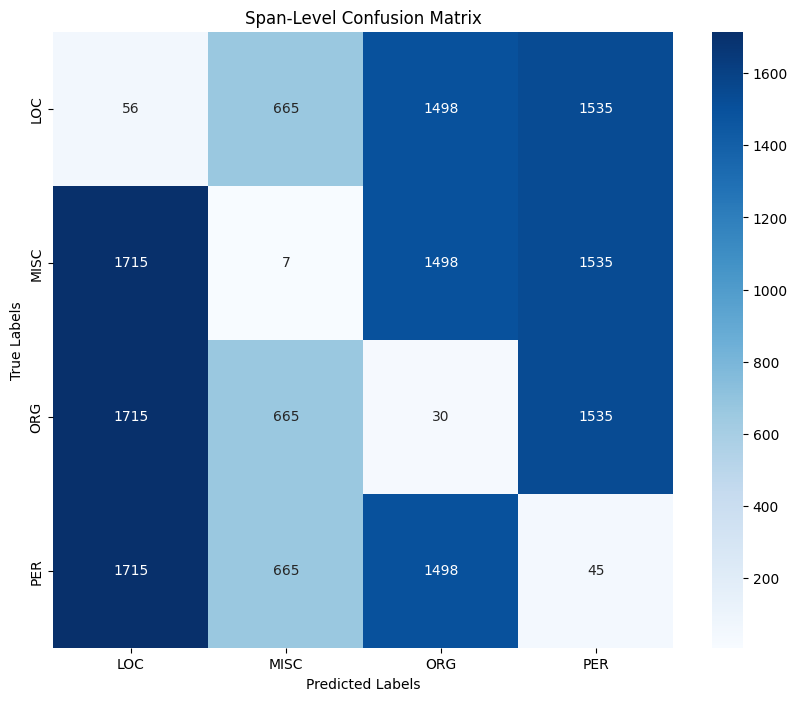


Overall - Precision: 0.02, Recall: 0.02, F1-Score: 0.02
Training and evaluating model: logreg
Features used: {'token': 'SOCCER', 'pos_tag': 'NN', 'chunk_tag': 'B-NP', 'capitalized': True, 'contains_digit': False, 'word_frequency': 0.00442664418212479, 'token_length_bin': 'bin_1', 'prev_pos_tag': '<START>', 'next_pos_tag': ':', 'prefix_2': 'SO', 'suffix_2': 'ER', 'prefix_3': 'SOC', 'suffix_3': 'CER'} + Embeddings: None
Evaluation results for logreg:
LOC - Precision: 0.03, Recall: 0.03, F1-Score: 0.03
MISC - Precision: 0.01, Recall: 0.01, F1-Score: 0.01
ORG - Precision: 0.02, Recall: 0.01, F1-Score: 0.01
PER - Precision: 0.03, Recall: 0.03, F1-Score: 0.03


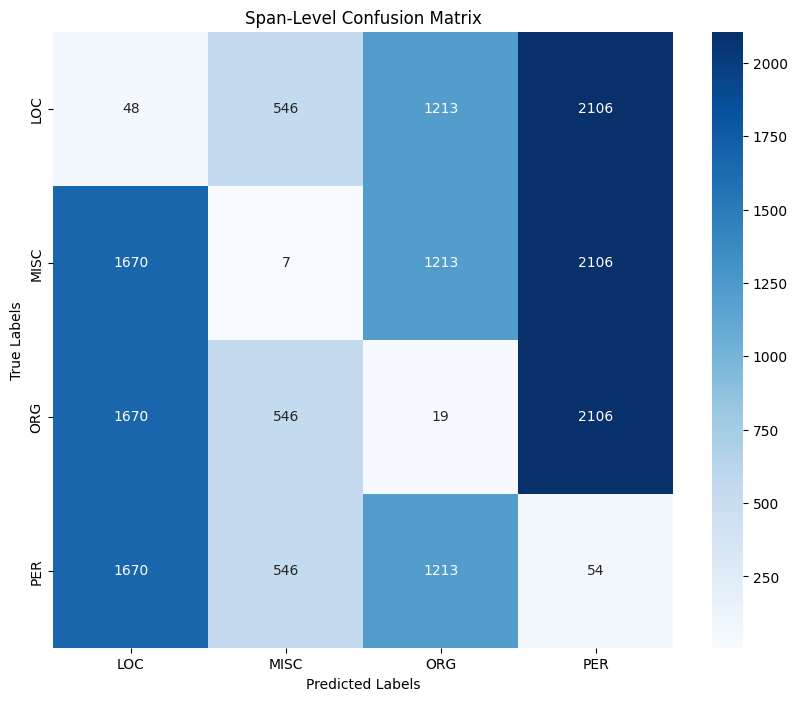


Overall - Precision: 0.02, Recall: 0.02, F1-Score: 0.02
Training and evaluating model: NB
Features used: {'token': 'SOCCER', 'pos_tag': 'NN', 'chunk_tag': 'B-NP', 'capitalized': True, 'contains_digit': False, 'word_frequency': 0.00442664418212479, 'token_length_bin': 'bin_1', 'prev_pos_tag': '<START>', 'next_pos_tag': ':', 'prefix_2': 'SO', 'suffix_2': 'ER', 'prefix_3': 'SOC', 'suffix_3': 'CER'} + Embeddings: None
Evaluation results for NB:
LOC - Precision: 0.03, Recall: 0.04, F1-Score: 0.04
MISC - Precision: 0.01, Recall: 0.01, F1-Score: 0.01
ORG - Precision: 0.02, Recall: 0.02, F1-Score: 0.02
PER - Precision: 0.03, Recall: 0.03, F1-Score: 0.03


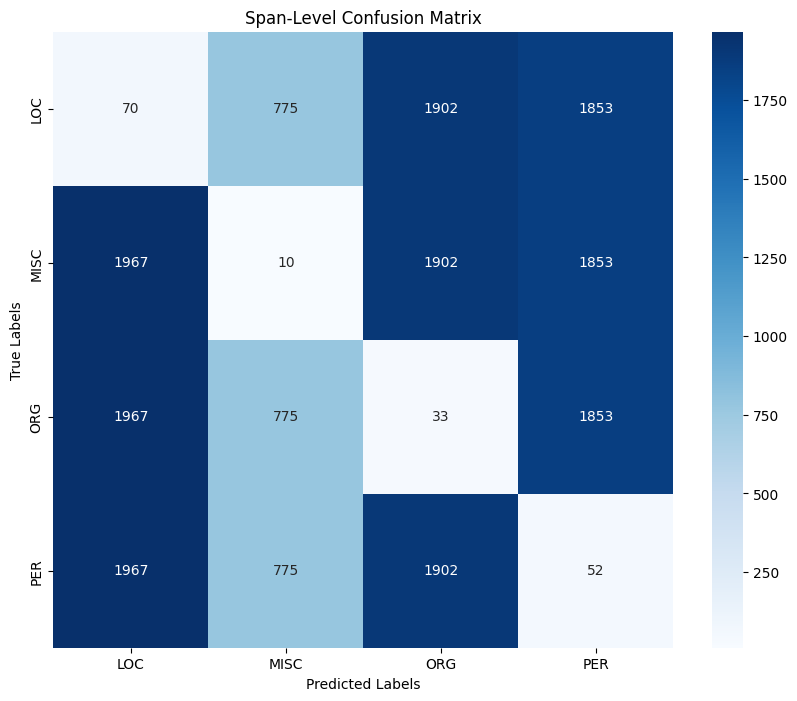


Overall - Precision: 0.02, Recall: 0.03, F1-Score: 0.03


In [16]:
pred_file_base = "./results/log_results"
feature_list = ['token', 'pos_tag', 'chunk_tag', 'capitalized', 'contains_digit', 'word_frequency', 
                'token_length_bin', 'prev_pos_tag', 'next_pos_tag', 'prefix_2', 'suffix_2', 'prefix_3', 'suffix_3', 'embedding'
]

# features_to_remove = ['token', 'capitalized', 'token_length', 'word_frequency', 'token_length_bin', 
#                       'prefix_2', 'suffix_2', 'prefix_3', 'suffix_3']
features_to_remove = ['token', 'capitalized', 'token_length', 'word_frequency', 'token_length_bin', 
                      'prefix_2', 'suffix_2', 'prefix_3', 'suffix_3']

features_no_embeddings = feature_list[:-1]  
train_data_no_embeddings = remove_embedding_from_features(train_data)

train_features_svm = remove_specified_features(train_data, features_to_remove)
# print(train_features_svm[0])
embeddings = False

for model_name in ['SVM', 'logreg', 'NB']:
    print(f"Training and evaluating model: {model_name}")
    pred_file = f"{pred_file_base}_{model_name}.conll"

    # Determine whether to use embeddings
    if model_name == "SVM":
        ml_model, vec = create_classifier(train_features=train_features_svm, train_targets=train_targets,
                                          model_type=model_name, max_iter=10000, use_embeddings=True)
        feature_list_used = feature_list  # Include embeddings
        embeddings = True
    else:
        ml_model, vec = create_classifier(train_features=train_data_no_embeddings, train_targets=train_targets,
                                          model_type=model_name, max_iter=10000, use_embeddings=False)
        feature_list_used = features_no_embeddings  # Exclude embeddings
        embeddings = False

    classify_data(model=ml_model, vec=vec, inputdata=test_file, outputfile=pred_file, feature_list=feature_list_used,
                   embeddings = embeddings, features_to_remove=features_to_remove)

    print(f"Evaluation results for {model_name}:")
    span_based_evaluation(test_file, pred_file)

### Hyperparam Optimization

In [17]:
def create_classifier_with_optuna(train_data, train_targets, max_trials=20):
    """
    Perform hyperparameter tuning for LinearSVC using Optuna with k-fold cross-validation.
    """

    vec = DictVectorizer()
    
    # Handle train embeddings
    train_embeddings = np.array([feature['embedding'] for feature in train_data])
    train_features_no_embeddings = remove_embedding_from_features(train_data)
    train_categorical_features = vec.fit_transform(train_features_no_embeddings)
    train_features_combined = np.hstack([train_categorical_features.toarray(), train_embeddings])

    study = optuna.create_study(direction='maximize')
    study.optimize(lambda trial: objective(trial, train_features_combined, train_targets), n_trials=max_trials)
    best_params = study.best_params
    print(f"Best Parameters: {best_params}")

    best_model = LinearSVC(**best_params, max_iter=10000, dual=False)
    best_model.fit(train_features_combined, train_targets)

    return best_model, vec, best_params

def objective(trial, features, targets):
    """Objective function for Optuna with k-fold cross-validation."""
    # Hyperparameter space
    C = trial.suggest_float('C', 1e-2, 1, log = True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    loss = trial.suggest_categorical('loss', ['hinge', 'squared_hinge'])
    tol = trial.suggest_float('tol', 1e-4, 1e-1, log = True)

    if (penalty == 'l1' and loss != 'squared_hinge') or (penalty == 'l2' and loss == 'hinge'):
        raise optuna.exceptions.TrialPruned()

    model = LinearSVC(C=C, penalty=penalty, loss=loss, dual=False, max_iter=1000, tol=tol)
    targets = np.array(targets)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    f1_scores = []

    for train_index, val_index in skf.split(features, targets):
        X_train, X_val = features[train_index], features[val_index]
        y_train, y_val = targets[train_index], targets[val_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        f1 = f1_score(y_val, y_pred, average='weighted')
        f1_scores.append(f1)

    return np.mean(f1_scores)

In [18]:
dev_features_svm = remove_specified_features(dev_data, features_to_remove)

# Train and tune model using train and dev sets
best_svm_model, vec, best_params = create_classifier_with_optuna(
    train_features_svm, train_targets,
    max_trials=20
)

# Save predictions on test set
test_file = data_folder + "conll2003.test.conll"
pred_file_test = "./results/svm_test_results.conll"

classify_data(best_svm_model, vec, inputdata=test_file, outputfile=pred_file_test,
              feature_list=feature_list, embeddings=True, features_to_remove=features_to_remove)

# Final evaluation on test set
print("Final evaluation results on test set:")
span_based_evaluation(test_file, pred_file_test)


[I 2024-11-22 15:30:15,470] A new study created in memory with name: no-name-c2e5898d-5020-45c2-ab39-21eaa2a3deb0
